# Research Assistant

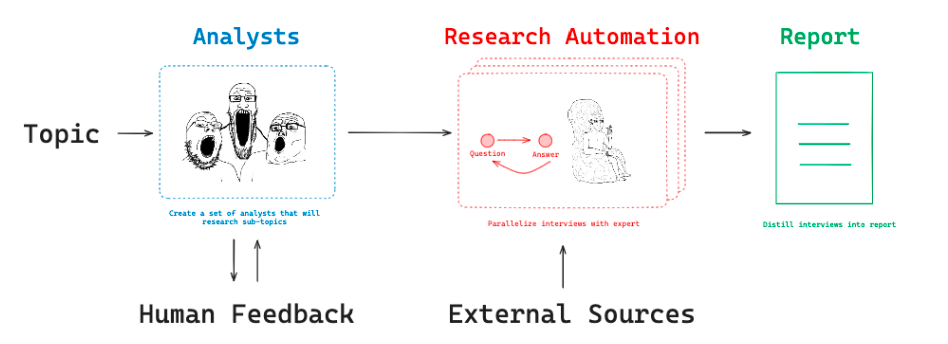

# Config

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("config.properties")

APIKey = config.get("AzureCredentials","APIKey").strip()
Endpoint = config.get("AzureCredentials","Endpoint").strip()
Deployment = config.get("AzureCredentials","Deployment").strip()
version = config.get("AzureCredentials","version").strip()

Googlekey = config.get('GoogleCred','key')


In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(temperature = 0.2,
                                deployment_name=Deployment,
                                openai_api_version=version,
                                openai_api_key=APIKey, 
                                azure_endpoint=Endpoint)
llm.invoke("Hi")



AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f3927aa00d', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-ec218049-abb4-47e3-a9c3-e5d2393d1572-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Analyst

In [1]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field



class Analyst(BaseModel):
    affiliation: str= Field(
        description="Primary affiliation of the analyst",
    )
    name: str =Field(
        description= "Name of the Analyst"
    )
    role: str = Field(
        description = "Role of the analyst in the context of the topic."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"



class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )



class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""



def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [5]:
def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

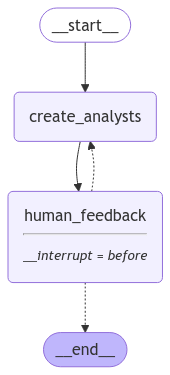

In [6]:

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])



# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [7]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Alice Thompson
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Thompson focuses on the technical aspects of AI frameworks, analyzing their architecture and performance metrics. She is particularly interested in how LangGraph can enhance agent-based systems.
--------------------------------------------------
Name: Mr. John Carter
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Carter examines the ethical implications of adopting AI frameworks like LangGraph. He is concerned with transparency, accountability, and the societal impacts of AI agents.
--------------------------------------------------
Name: Ms. Emily Zhang
Affiliation: Business Solutions Consultancy
Role: Business Strategy Analyst
Description: Ms. Zhang evaluates the business benefits of implementing LangGraph as an agent framework. She focuses on ROI, efficiency improvements, and competitive advantages for organizations.
-----------------------------

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0efd-d2a4-6e57-8002-ac7c85f9e683'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Alice Thompson
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Thompson focuses on the technical aspects of AI frameworks, analyzing their architecture and performance metrics. She is particularly interested in how LangGraph can enhance agent-based systems.
--------------------------------------------------
Name: Mr. John Carter
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Carter examines the ethical implications of adopting AI frameworks like LangGraph. He is concerned with transparency, accountability, and the societal impacts of AI agents.
--------------------------------------------------
Name: Ms. Emily Zhang
Affiliation: Business Solutions Consultancy
Role: Business Strategy Analyst
Description: Ms. Zhang evaluates the business benefits of implementing LangGraph as an agent framework. She focuses on ROI, efficiency improvements, and competitive advantages for organizations.
-----------------------------

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0efe-b1da-6079-8004-396564bd016c'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alice Johnson
Affiliation: Tech Innovators Inc.
Role: AI Researcher
Description: Alice focuses on the technical aspects of AI frameworks, particularly their scalability and integration capabilities. She is concerned with how LangGraph can enhance AI agent performance.
--------------------------------------------------
Name: Mark Thompson
Affiliation: Startup Hub
Role: Entrepreneur
Description: Mark is a startup founder interested in the practical applications of AI frameworks in business. He is keen on understanding how adopting LangGraph can provide competitive advantages for new ventures.
--------------------------------------------------
Name: Dr. Sarah Lee
Affiliation: University of Technology
Role: Academic Researcher
Description: Dr. Lee specializes in AI ethics and policy. She is focused on the implications of adopting frameworks like LangGraph on data privacy and ethical AI usage.
--------------------------------------------------


# Conduct Interview

In [16]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API



class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [17]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

# Generate Answer: Parallelization

In [18]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://python.langchain.com/v0.2/docs/tutorials/rag/")

loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


[Document(metadata={'source': 'https://python.langchain.com/v0.2/docs/tutorials/rag/', 'title': 'Build a Retrieval Augmented Generation (RAG) App | 🦜️🔗 LangChain', 'description': 'One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information. These applications use a technique known as Retrieval Augmented Generation, or RAG.', 'language': 'en'}, page_content='\n\n\n\n\nBuild a Retrieval Augmented Generation (RAG) App | 🦜️🔗 LangChain\n\n\n\n\n\n\n\nSkip to main contentA newer LangChain version is out! Check out the latest version.IntegrationsAPI referenceLatestLegacyMorePeopleContributingCookbooks3rd party tutorialsYouTubearXivv0.2Latestv0.2v0.1🦜️🔗LangSmithLangSmith DocsLangChain HubJS/TS Docs💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a Simple LLM Application with LCELBuild a Query Analysis SystemBuild 

In [19]:
loader.load()[0].page_content

'\n\n\n\n\nBuild a Retrieval Augmented Generation (RAG) App | 🦜️🔗 LangChain\n\n\n\n\n\n\n\nSkip to main contentA newer LangChain version is out! Check out the latest version.IntegrationsAPI referenceLatestLegacyMorePeopleContributingCookbooks3rd party tutorialsYouTubearXivv0.2Latestv0.2v0.1🦜️🔗LangSmithLangSmith DocsLangChain HubJS/TS Docs💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a Simple LLM Application with LCELBuild a Query Analysis SystemBuild a ChatbotConversational RAGBuild an Extraction ChainBuild an AgentTaggingdata_generationBuild a Local RAG ApplicationBuild a PDF ingestion and Question/Answering systemBuild a Retrieval Augmented Generation (RAG) AppVector stores and retrieversBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to map values to a graph datab

In [20]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

In [21]:
from langchain_core.tools import tool
from langchain_community.document_transformers import Html2TextTransformer
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.utilities import GoogleSearchAPIWrapper
from duckduckgo_search import DDGS
import os

os.environ["GOOGLE_CSE_ID"] = config.get('GoogleCred','GOOGLE_CSE_ID')
os.environ["GOOGLE_API_KEY"] = config.get('GoogleCred','GOOGLE_API_KEY')

html2text = Html2TextTransformer()
from langchain_core.tools import Tool

def scrapeFromURLs(URLs):
    if isinstance(URLs,str):
        URLs = [URLs]
    loader = AsyncHtmlLoader(URLs,ignore_load_errors=True)
    docs = loader.load() 
    docs_transformed = html2text.transform_documents(docs)
    return docs_transformed


search = GoogleSearchAPIWrapper()
def TopGoogleResult(query):
    return search.results(query, 10)

# ______________________________________________________ DuckDuckGO
def top5_it_results(query):
    results = DDGS().text(query, max_results=10)
    return results

Gtool = Tool(
        name="Google Search Snippets",
        description="Search Google for problem's solution.",
        func=TopGoogleResult,
    )

def refactor(Docs):
    try:
        if isinstance(Docs,str):
            Docs = [Docs]
        _refactorList = []
        for doc in Docs:
            WebTemplate = f"""You are Advance refactor for web scrapped text and you give the most relevant information from the messy document ,here is the new web Ducument:'{doc}' , please provide only the relevant answer within 80 words for user question only ,response:"""
            _refactorList.append(llm.invoke(WebTemplate).content.replace('{','}').replace('}','{'))
        return _refactorList
    except Exception as e:
        print("Azure interuption.....")
        return [f"The website contains in appropriate data so it was filtered,guradrail interuption "]


def search_web(state: InterviewState):
    try:
        webpages_to_include = 3

        structured_llm = llm.with_structured_output(SearchQuery)
        search_query = structured_llm.invoke([search_instructions]+state['messages']).search_query
        
        Gresult = Gtool.run(search_query)
        Dtool = Tool(
            name="Google Search Snippets",
            description="Search Google for problem's solution.",
            func=top5_it_results,
        )
        # Dresult = Dtool.run(user_text) 

        allResult = Gresult #+ Dresult 
        web_URL = [website.get("link",website.get("href")) for website in allResult]
        web_URL =list(set(web_URL))
        idx = 0 
        document_list = []
        for _, URL in enumerate(web_URL):
            try:
                # WebPageData = refactor(scrapeFromURLs(URL))
                WebPageData = scrapeFromURLs(URL)
                document_list.append(
                    f"""URL:{URL} <document>{WebPageData} </documenet>"""
                )
                if WebPageData[0] in ['' ,None]:
                    continue
            except Exception as e :
                print(f"Skipping..........{e}")
                continue
            idx = idx + 1
            if webpages_to_include == idx:
                break
        print(document_list)
        return {"context": ["\n\n---\n\n".join(document_list)]} 
    except Exception as e:
        print(e)



USER_AGENT environment variable not set, consider setting it to identify your requests.
C:\Users\SIVERMA\AppData\Local\Temp\ipykernel_11764\1085156307.py:23: LangChainDeprecationWarning: The class `GoogleSearchAPIWrapper` was deprecated in LangChain 0.0.33 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-google-community package and should be used instead. To use it run `pip install -U :class:`~langchain-google-community` and import as `from :class:`~langchain_google_community import GoogleSearchAPIWrapper``.
  search = GoogleSearchAPIWrapper()


In [22]:
def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [23]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""



def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}



In [24]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}


def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

In [25]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [26]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

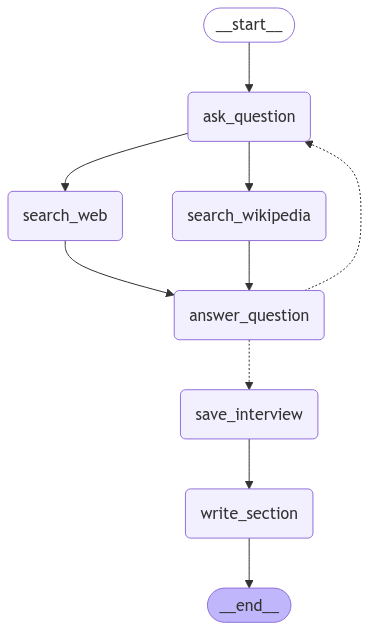

In [27]:

interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [28]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Alice Johnson', role='AI Researcher', description='Alice focuses on the technical aspects of AI frameworks, particularly their scalability and integration capabilities. She is concerned with how LangGraph can enhance AI agent performance.')

In [29]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 1}, thread)

Markdown(interview['sections'][0])

Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.14s/it]


["URL:https://github.com/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb <document>[Document(metadata={'source': 'https://github.com/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb', 'title': 'langchain-academy/module-4/research-assistant.ipynb at main · langchain-ai/langchain-academy · GitHub', 'description': 'Contribute to langchain-ai/langchain-academy development by creating an account on GitHub.', 'language': 'en'}, page_content='Skip to content\\n\\n## Navigation Menu\\n\\nToggle navigation\\n\\nSign in\\n\\n  * Product \\n\\n    * GitHub Copilot\\n\\nWrite better code with AI\\n\\n    * Security\\n\\nFind and fix vulnerabilities\\n\\n    * Actions\\n\\nAutomate any workflow\\n\\n    * Codespaces\\n\\nInstant dev environments\\n\\n    * Issues\\n\\nPlan and track work\\n\\n    * Code Review\\n\\nManage code changes\\n\\n    * Discussions\\n\\nCollaborate outside of code\\n\\n    * Code Search\\n\\nFind more, search less\\n\\nE

## Enhancing AI Agent Performance through LangGraph Integration

### Summary
The integration of AI frameworks into industrial applications is becoming increasingly vital as organizations seek to enhance operational efficiency and scalability. LangGraph, a framework designed for building stateful, multi-actor applications using large language models (LLMs), stands out for its ability to facilitate complex workflows through a graph-based approach. This novel method allows for fine-grained control over data processing, making it particularly suitable for environments that require real-time data handling and multi-agent interactions.

Recent insights reveal that LangGraph not only supports diverse agent types but also excels in memory management, enabling agents to maintain context across interactions. This capability is crucial for applications that demand continuous learning and adaptation, such as predictive maintenance and supply chain optimization. The framework's integration with tools like XMPro DataStreams enhances its scalability, allowing organizations to deploy intelligent systems that can handle increasing data volumes effectively.

1. The first source discusses the capabilities of LangGraph in building AI agents and its advantages in managing complex workflows [1].
2. The second source highlights the importance of data pipelines in industrial settings and how they can be leveraged alongside multi-agent generative systems (MAGS) for real-time data processing [2].
3. The third source compares LangGraph with other frameworks, emphasizing its strengths in memory support and multi-agent interaction patterns [3].

Interestingly, the combination of LangGraph with XMPro's DataStreams creates a robust ecosystem that not only supports real-time data processing but also allows for the deployment of various agent types, from sophisticated AI to simple scripts. This versatility is essential for addressing real-world industrial challenges, such as energy management and quality control, where different agents can be tailored to specific tasks.

Moreover, the ability to visualize workflows as graphs simplifies the management of complex interactions, making it easier for developers to design and optimize their systems. This feature, combined with comprehensive documentation and community support, positions LangGraph as a leading choice for organizations looking to enhance their AI capabilities.

### Sources
[1] https://github.com/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb  
[2] https://www.linkedin.com/pulse/scaling-multi-agent-systems-data-pipelines-solving-van-schalkwyk-dd2uc  
[3] https://www.galileo.ai/blog/mastering-agents-langgraph-vs-autogen-vs-crew  

In [30]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [31]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(content=f"So you said you were writing an article on {topic}?")]}) for analyst in state["analysts"]]

In [32]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2


Here are the memos from your analysts to build your report from: 

{context}"""

In [33]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [34]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [35]:

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [36]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [37]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

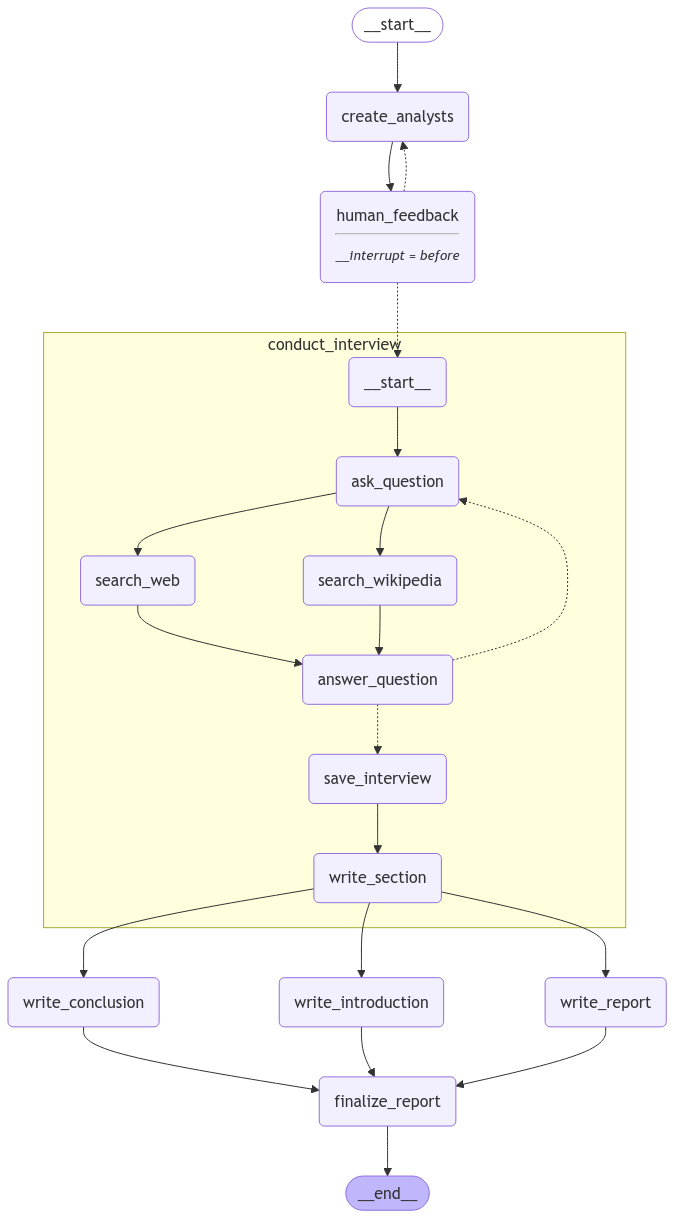

In [39]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)



# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [40]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Alice Thompson
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Thompson focuses on the technical advantages of adopting new AI frameworks, particularly LangGraph. She is interested in performance metrics, scalability, and integration with existing systems.
--------------------------------------------------
Name: Mr. John Carter
Affiliation: Future of Work Institute
Role: Organizational Change Consultant
Description: Mr. Carter examines the impact of AI frameworks like LangGraph on organizational structures and workflows. He is concerned with how these technologies can enhance productivity and employee engagement.
--------------------------------------------------
Name: Ms. Sarah Lee
Affiliation: Data Ethics Alliance
Role: Ethics and Compliance Analyst
Description: Ms. Lee analyzes the ethical implications of adopting AI frameworks. She is focused on data privacy, compliance with regulations, and the societal impacts of AI technologies like La

In [41]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0f59-8a65-68d9-8002-df1daf9b3b43'}}

In [42]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Alice Thompson
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Thompson focuses on the technical advantages of adopting new AI frameworks, particularly LangGraph. She is interested in performance metrics, scalability, and integration with existing systems.
--------------------------------------------------
Name: Mr. John Carter
Affiliation: Future of Work Institute
Role: Organizational Change Consultant
Description: Mr. Carter examines the impact of AI frameworks like LangGraph on organizational structures and workflows. He is concerned with how these technologies can enhance productivity and employee engagement.
--------------------------------------------------
Name: Ms. Sarah Lee
Affiliation: Data Ethics Alliance
Role: Ethics and Compliance Analyst
Description: Ms. Lee analyzes the ethical implications of adopting AI frameworks. She is focused on data privacy, compliance with regulations, and the societal impacts of AI technologies like La

In [43]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0f5a-4e9c-6725-8004-231c4ea4894a'}}

In [ ]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [ ]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)